#Mini Project-1 AIML

Deployed WebAPP Link [Link](https://a564-34-125-169-213.ngrok-free.app/)

###Important libs, repositories and packages for IndicTrans2

In [1]:
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [2]:
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [3]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransToolkit.git
%cd IndicTransToolkit
!python3 -m pip install --editable ./
%cd ..

##Using Image Captioning Model : [blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) to get the camtion given an image.

### Following is done below:


1.   installing Transformers, torch, torchvision and pillow
2.   instantiating the model
3.   setting it ready in evaluation mode without any external training and fine tuning



In [1]:
!pip install transformers torch torchvision pillow

In [2]:
import torch

In [3]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

captioning_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
captioning_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

captioning_model.eval()

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

### Making a function to load the image using PIL's Image

In [4]:
def load_image(image_path):
    image = Image.open(image_path)
    return image

###Making a function to generate the cation of any image using the vit-gpt2-image-captioning model

In [5]:
def generate_caption(image_path):
    image = load_image(image_path)
    inputs = captioning_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        output_ids = captioning_model.generate(**inputs)

    caption = captioning_processor.decode(output_ids[0], skip_special_tokens=True)
    return caption

###Generating the caption for 3 sample images

In [6]:
images = ['/content/TI1.jpg', '/content/TI2.jpeg', '/content/TI3.jpeg']
captions = []
for image in images:
    captions.append(generate_caption(image))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


###Dislaying image and captions

Image 1:


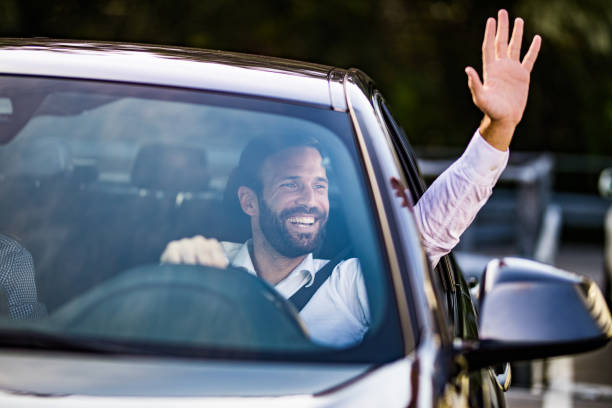

Caption: a man waving out his hand in a car

Image 2:


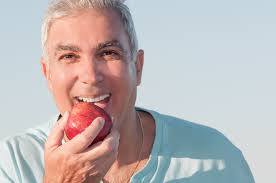

Caption: a man eating an apple

Image 3:


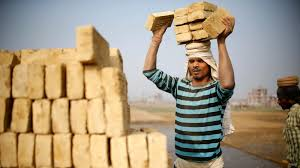

Caption: a man carrying a large pile of bricks



In [ ]:
for i in range(len(images)):
    print(f"Image {i+1}:")
    display(Image.open(images[i]))
    print(f"Caption: {captions[i]}\n")

##Using [ai4bharat/indictrans2-en-indic-1B](https://huggingface.co/ai4bharat/indictrans2-en-indic-1B) for text-to-text translation

### Following is done below:


1.   instantiating the model
2.   setting it ready in evaluation mode without any external training and fine tuning

NOTE: The following code id taken from official wwebsite of ai4bharat



In [7]:
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoTokenizer
from IndicTransToolkit import IndicProcessor

In [8]:
BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [9]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text

        with tokenizer.as_target_tokenizer():
            generated_tokens = tokenizer.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

In [10]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

tokenization_indictrans.py:   0%|          | 0.00/8.10k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json:   0%|          | 0.00/645k [00:00<?, ?B/s]

dict.TGT.json:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

###Testing the Translation model

In [11]:
tgt_lang = "hin_Deva"

In [12]:
src_lang = "eng_Latn"
translated_captions = batch_translate(captions, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [13]:
captions

['a man waving out his hand in a car',
 'a man eating an apple',
 'a man carrying a large pile of bricks']

In [14]:
translated_captions

['एक आदमी कार में अपना हाथ हिला रहा है ',
 'एक आदमी एक सेब खा रहा है ',
 'ईंटों का एक बड़ा ढेर ले जा रहा एक आदमी ']

##Using [gTTS](https://gtts.readthedocs.io/en/latest/index.html) Performing speech synthesis on translated captions

In [12]:
!pip install gTTS

###Instantiating gTTS and testing it on of the translated sample

In [ ]:
from gtts import gTTS
tts = gTTS(text = translated_captions[2], lang = "te", slow = False)
tts.save("caption1.mp3")

In [17]:
from IPython.display import Audio
Audio("caption1.mp3")

## Generating a final pipeline to combine these models


### A set of languages availabe in IndicTrans2 as well as gTTS. For smooth pronunciation

In [18]:
language_dict = {
    'bengali': ("ben_Beng", 'bn'),
    'english': ("eng_Latn", 'en'),
    'gujarati': ("guj_Gujr", 'gu'),
    'hindi': ("hin_Deva", 'hi'),
    'marathi': ("mar_Deva", 'mr'),
    'nepali': ("npi_Deva", 'ne'),
    'tamil': ("tam_Taml", 'ta'),
    'telugu': ("tel_Telu", 'te'),
    'urdu': ("urd_Arab", 'ur')
}

### Pipeline function

In [ ]:
def image_to_speech(image_path):
  caption = generate_caption(image_path)

  choice = input("Enter the target Language(Refer the table above): ")
  Language = language_dict[choice.lower()]
  tgt_lang = Language[0]
  src_lang = "eng_Latn"
  translated_caption = batch_translate([caption], src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)[0]

  tts = gTTS(text = translated_caption, lang = Language[1], slow = False)
  audio_path = "out.mp3"
  tts.save(audio_path)

  display(Image.open(image_path))

  return Audio(audio_path, autoplay = True)

### Testing the pipeline

These are the possible options for the Language you may get translations into.

|S. No.| Language  | Translation Code  | Speech Code |
|------|-----------|-------------------|-------------|
|1     | Bengali   | ben_Beng           | bn          |
|2     | English   | eng_Latn           | en          |
|3     | Gujarati  | guj_Gujr           | gu          |
|4     | Hindi     | hin_Deva           | hi          |
|5     | Marathi   | mar_Deva           | mr          |
|6     | Nepali    | npi_Deva           | ne          |
|7     | Tamil     | tam_Taml           | ta          |
|8     | Telugu    | tel_Telu           | te          |
|9     | Urdu      | urd_Arab           | ur          |


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Enter the target Language(Refer the table above): Gujarati


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


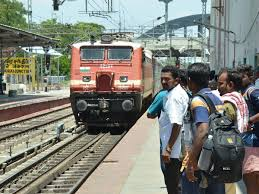

In [ ]:
image_to_speech("/content/test1.jpeg")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Enter the target Language(Refer the table above): Marathi


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


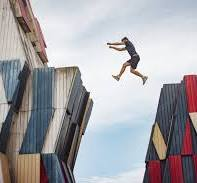

In [ ]:
image_to_speech("/content/test2.jpeg")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Enter the target Language(Refer the table above): Bengali


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


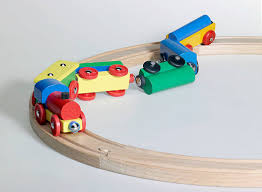

In [ ]:
image_to_speech("/content/test3.jpeg")

##Making the Web APP using Streamlit

In [3]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


###Making the Web app file

In [45]:
%%writefile app.py
import streamlit as st
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoTokenizer, BlipProcessor, BlipForConditionalGeneration
from IndicTransToolkit import IndicProcessor
from PIL import Image
from gtts import gTTS
import os

# Initialize global variables
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4

# Language Dictionary for IndicTrans2 and gTTS
language_dict = {
    'bengali': ("ben_Beng", 'bn'),
    'english': ("eng_Latn", 'en'),
    'gujarati': ("guj_Gujr", 'gu'),
    'hindi': ("hin_Deva", 'hi'),
    'marathi': ("mar_Deva", 'mr'),
    'nepali': ("npi_Deva", 'ne'),
    'tamil': ("tam_Taml", 'ta'),
    'telugu': ("tel_Telu", 'te'),
    'urdu': ("urd_Arab", 'ur')
}

# BLIP Model and Processor Initialization
@st.cache_resource  # Cache the BLIP model to avoid reloading
def initialize_captioning_model():
    captioning_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    captioning_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    captioning_model.eval()
    return captioning_processor, captioning_model

# IndicTrans2 Model and Tokenizer Initialization
@st.cache_resource  # Cache the translation model and tokenizer
def initialize_translation_model(ckpt_dir, quantization=None):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig is None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()
    return tokenizer, model

# Image Captioning Function
def generate_caption(image, processor, model):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        output_ids = model.generate(**inputs)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption

# Translation Function
def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text
        with tokenizer.as_target_tokenizer():
            generated_tokens = tokenizer.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

# Image-to-Speech Function
def generate_speech(caption, tgt_lang_code):
    tts = gTTS(text=caption, lang=tgt_lang_code, slow=False)
    audio_path = "translated_caption.mp3"
    tts.save(audio_path)
    return audio_path

# Streamlit App
def main():
    st.title("Automatic-Image-Captioning-and-Speech-Synthesis-for-Blind-People")
    st.write("By Rajeev Goel")

    # Load BLIP model
    captioning_processor, captioning_model = initialize_captioning_model()

    # Load IndicTrans2 model
    ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"
    quantization = None
    en_indic_tokenizer, en_indic_model = initialize_translation_model(ckpt_dir, quantization)
    ip = IndicProcessor(inference=True)

    col1, col2 = st.columns([2, 1])

    with col1:
        uploaded_file = st.file_uploader("Upload an Image", type=["png", "jpg", "jpeg"])
        placeholder_caption = st.empty()  # Placeholder for dynamic caption
        placeholder_translation = st.empty()  # Placeholder for translation
        placeholder_audio = st.empty()  # Placeholder for audio playback

    with col2:
        choice = st.selectbox("Select Target Language", list(language_dict.keys()))
        tgt_lang, tgt_lang_code = language_dict[choice.lower()]

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Generate caption, translate, and convert to speech
        if st.button("Generate Caption, Translate, and Speak"):
            caption = generate_caption(image, captioning_processor, captioning_model)
            st.subheader("Generated Caption:")
            st.write(caption)

            # Translate caption
            src_lang = "eng_Latn"
            translated_caption = batch_translate([caption], src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)[0]
            st.subheader("Translated Caption:")
            st.write(translated_caption)

            # Generate speech
            audio_path = generate_speech(translated_caption, tgt_lang_code)
            st.audio(audio_path)

            # Remove temporary audio file
            if os.path.exists(audio_path):
                os.remove(audio_path)

    st.markdown("---")
    st.write("Made with ❤️ by [Rajeev Goel](https://github.com/RajeevG187/Automatic-Image-Captioning-and-Speech-Synthesis-for-Blind-People)")

if __name__ == "__main__":
    main()


Overwriting app.py


###Generating the web app link for the project and running it

In [46]:
from pyngrok import ngrok

!ngrok config add-authtoken "2p70efwJtwsUylsEnuRGzHpS4er_DtahsDndieq4eQuGGQzM"

# Start an ngrok tunnel
public_url = ngrok.connect(addr=8501)
print("Streamlit app URL:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app URL: NgrokTunnel: "https://a564-34-125-169-213.ngrok-free.app" -> "http://localhost:8501"


CLICK on the link after running the below command

In [47]:
!streamlit run app.py &>/content/logs.txt &